# Evaluando modelos de Machine Learning

In [74]:
#Importaciones
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Preparamos dataset

In [75]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()

df_stroke = pd.read_csv('datasets/healthcare-dataset-stroke-data.csv')
df_stroke['age']=df_stroke['age'].round(0).astype(int)



#Reemplazamos nulos
df_stroke.fillna(df_stroke.mean(),inplace=True);
df_stroke.isnull().values.any();
df_stroke.isnull().sum;



Creamos nuevas variables

In [76]:
# Comorbilidades (más de una condición médica)
df_stroke['comorbidities'] = df_stroke[['hypertension', 'heart_disease', 'stroke']].sum(axis=1)

# Grupos de edades:
df_stroke['age_group'] = pd.cut(df_stroke['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'])

# Niveles de actividades en función de la profesión y la residencia
conditions = [    (df_stroke['work_type'] == 'Never_worked') | (df_stroke['work_type'] == 'children'),
    (df_stroke['work_type'] == 'Self-employed') & (df_stroke['Residence_type'] == 'Rural'),
    (df_stroke['work_type'] == 'Self-employed') & (df_stroke['Residence_type'] == 'Urban'),
    (df_stroke['work_type'] == 'Private') & (df_stroke['Residence_type'] == 'Rural'),
    (df_stroke['work_type'] == 'Private') & (df_stroke['Residence_type'] == 'Urban'),
    (df_stroke['work_type'] == 'Govt_job') & (df_stroke['Residence_type'] == 'Rural'),
    (df_stroke['work_type'] == 'Govt_job') & (df_stroke['Residence_type'] == 'Urban')
]

values = [1, 2, 3, 2, 3, 2, 3]

df_stroke['activity_level_residence'] = np.select(conditions, values)

df_stroke.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,comorbidities,age_group,activity_level_residence
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,2,60-70,3
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,1,60-70,2
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,2,70-80,2
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,1,40-50,3
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,2,70-80,2


Comprobamos tipos de datos de cada columna

In [77]:
cats = list(df_stroke.select_dtypes(include=['object','bool']) )
nums = list(df_stroke.select_dtypes(include=['int64','float64']))
print(cats)
print(nums)

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
['id', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke', 'comorbidities']


### Previa anterior, usamos todos los valores del dataset y los normalizamos y numerizamos

In [78]:
# Clasificamos datos para el encoding
encoder = []
onehot = []

for col in cats:
   if len(df_stroke[col].unique()) == 2:
        encoder.append(col)
   else:
        onehot.append(col)

print(encoder)
print(onehot)

['ever_married', 'Residence_type']
['gender', 'work_type', 'smoking_status']


In [79]:
df_labencoded = df_stroke.copy()

for col in encoder:
    df_labencoded[col] = df_labencoded[col].astype('category').cat.codes
df_labencoded.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,comorbidities,age_group,activity_level_residence
0,9046,Male,67,0,1,1,Private,1,228.69,36.600000,formerly smoked,1,2,60-70,3
1,51676,Female,61,0,0,1,Self-employed,0,202.21,28.893237,never smoked,1,1,60-70,2
2,31112,Male,80,0,1,1,Private,0,105.92,32.500000,never smoked,1,2,70-80,2
3,60182,Female,49,0,0,1,Private,1,171.23,34.400000,smokes,1,1,40-50,3
4,1665,Female,79,1,0,1,Self-employed,0,174.12,24.000000,never smoked,1,2,70-80,2


In [80]:
# Comprobamos la correlación de las features con el target
df_labencoded.corr().round(2)

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,comorbidities,activity_level_residence
id,1.00,0.00,0.00,-0.00,0.01,-0.00,0.00,0.00,0.01,0.00,0.01
age,0.00,1.00,0.28,0.26,0.68,0.01,0.24,0.33,0.25,0.41,0.49
hypertension,0.00,0.28,1.00,0.11,0.16,-0.01,0.17,0.16,0.13,0.73,0.09
heart_disease,-0.00,0.26,0.11,1.00,0.11,0.00,0.16,0.04,0.13,0.60,0.07
ever_married,0.01,0.68,0.16,0.11,1.00,0.01,0.16,0.34,0.11,0.20,0.42
Residence_type,-0.00,0.01,-0.01,0.00,0.01,1.00,-0.00,-0.00,0.02,0.00,0.62
avg_glucose_level,0.00,0.24,0.17,0.16,0.16,-0.00,1.00,0.17,0.13,0.24,0.08
bmi,0.00,0.33,0.16,0.04,0.34,-0.00,0.17,1.00,0.04,0.14,0.33
stroke,0.01,0.25,0.13,0.13,0.11,0.02,0.13,0.04,1.00,0.59,0.08
comorbidities,0.00,0.41,0.73,0.60,0.20,0.00,0.24,0.14,0.59,1.00,0.13


In [81]:
df = df_stroke.drop(['id'], axis=1)
nums.remove('id')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,comorbidities,age_group,activity_level_residence
0,Male,67,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,2,60-70,3
1,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,1,60-70,2
2,Male,80,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,2,70-80,2
3,Female,49,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,1,40-50,3
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,2,70-80,2


Borramos outliers

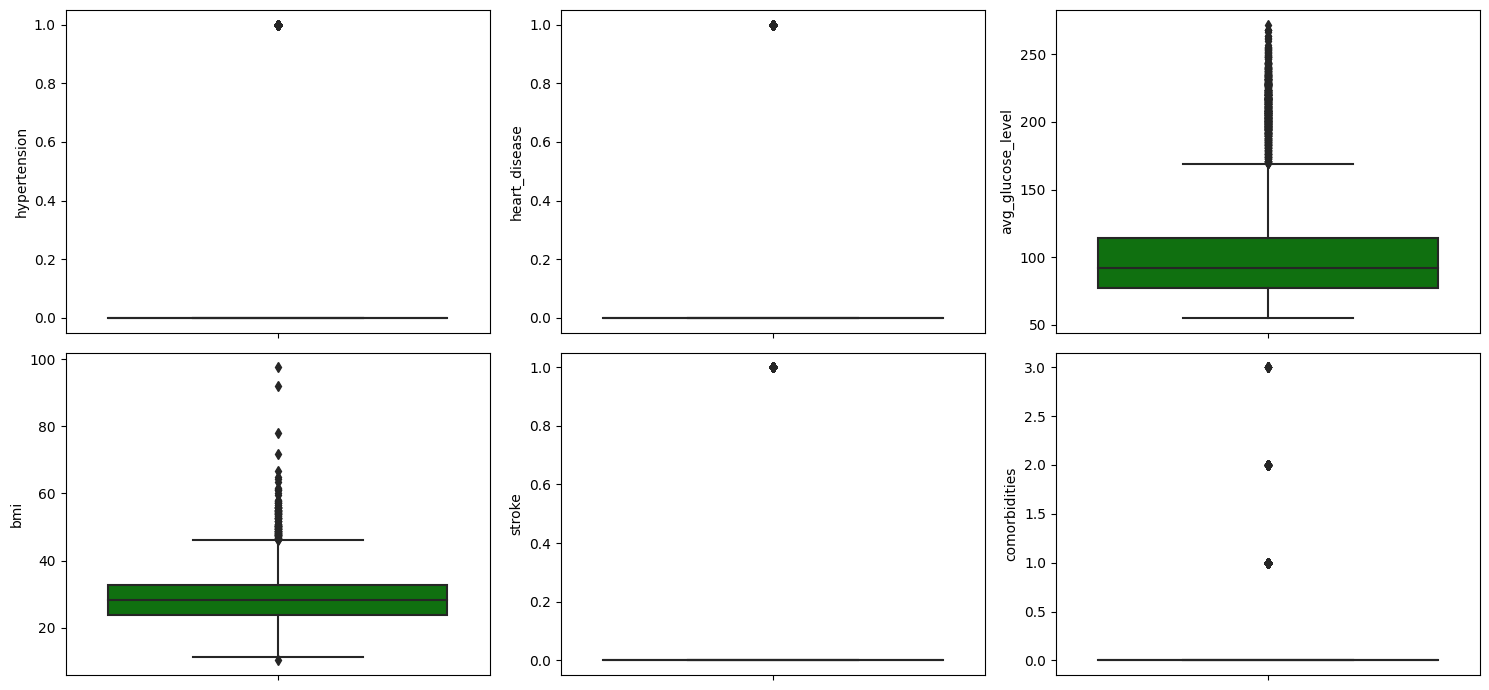

In [82]:
plt.figure(figsize=(15, 7))
for i in range(0, len(nums)):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[nums[i]],color='green',orient='v')
    plt.tight_layout()

In [83]:
outlier = ['avg_glucose_level', 'bmi']

In [84]:
# Calcula el valor del primer cuartil (25%)
Q1 = df[outlier].quantile(0.25)

# Calcula el valor del tercer cuartil (75%)
Q3 = df[outlier].quantile(0.75)

# Calcula la amplitud intercuartílica (IQR)
IQR = Q3 - Q1

# Selecciona solo las filas del dataframe que no tengan valores de la variable "outlier"
# por debajo del límite inferior (Q1 - 1.5*IQR) o por encima del límite superior (Q3 + 1.5*IQR)
# any(axis=1) indica que se deben eliminar las filas que tengan al menos un valor de "outlier"
# dentro de los límites establecidos
df = df[~((df[outlier]<(Q1-1.5*IQR))|(df[outlier]>(Q3+1.5*IQR))).any(axis=1)]

# Reinicia el índice del dataframe para que sea consecutivo
df.reset_index(drop=True)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,comorbidities,age_group,activity_level_residence
0,Male,80,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,2,70-80,2
1,Male,74,1,1,Yes,Private,Rural,70.09,27.400000,never smoked,1,3,70-80,2
2,Female,69,0,0,No,Private,Urban,94.39,22.800000,never smoked,1,1,60-70,3
3,Female,59,0,0,Yes,Private,Rural,76.15,28.893237,Unknown,1,1,50-60,2
4,Female,78,0,0,Yes,Private,Urban,58.57,24.200000,Unknown,1,1,70-80,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4386,Female,80,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0,1,70-80,3
4387,Female,81,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0,0,80-90,3
4388,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0,0,30-40,2
4389,Male,51,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0,0,50-60,2


Convertimos columnas categóricas a numéricas

In [85]:
# onehot encoding para categóricas
df = pd.get_dummies(df)
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,comorbidities,activity_level_residence,gender_Female,gender_Male,...,age_group_0-10,age_group_10-20,age_group_20-30,age_group_30-40,age_group_40-50,age_group_50-60,age_group_60-70,age_group_70-80,age_group_80-90,age_group_90-100
2,80,0,1,105.92,32.500000,1,2,2,0,1,...,0,0,0,0,0,0,0,1,0,0
6,74,1,1,70.09,27.400000,1,3,2,0,1,...,0,0,0,0,0,0,0,1,0,0
7,69,0,0,94.39,22.800000,1,1,3,1,0,...,0,0,0,0,0,0,1,0,0,0
8,59,0,0,76.15,28.893237,1,1,2,1,0,...,0,0,0,0,0,1,0,0,0,0
9,78,0,0,58.57,24.200000,1,1,3,1,0,...,0,0,0,0,0,0,0,1,0,0


## Modelado

Pasos previos

In [86]:
# separamos feature y target
X = df.drop(columns = ['stroke'])
y = df['stroke']

Usamos la técnica SMOTE (Synthetic Minority Over-sampling Technique) para el oversampling

In [87]:
# using SMOTE Techniqe
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=111)
X_sm , y_sm = sm.fit_resample(X,y)

print(f'''Shape of X before SMOTE:{X.shape}
Shape of X after SMOTE:{X_sm.shape}''',"\n\n")

print(f'''Target Class distributuion before SMOTE:\n{y.value_counts(normalize=True)}
Target Class distributuion after SMOTE :\n{y_sm.value_counts(normalize=True)}''')

Shape of X before SMOTE:(4391, 33)
Shape of X after SMOTE:(8452, 33) 


Target Class distributuion before SMOTE:
0    0.962423
1    0.037577
Name: stroke, dtype: float64
Target Class distributuion after SMOTE :
1    0.5
0    0.5
Name: stroke, dtype: float64


Dividimos datos para el entrenamiento y datos para el testing

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_sm,
    y_sm,
    test_size = .2,
    random_state = 111)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6761, 33), (6761,), (1691, 33), (1691,))

Normalizamos datos usando StandardScaler

In [89]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

### Usamos KNN para el modelado

In [90]:
from sklearn.neighbors import KNeighborsClassifier
baseline_model = KNeighborsClassifier()
baseline_model.fit(X_train, y_train)

KNeighborsClassifier()

In [91]:
y_pred = baseline_model.predict(X_test)

In [92]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
acc = accuracy_score(y_test, y_pred)
print('Testing-set Accuracy score is:', acc)
print('Training-set Accuracy score is:',accuracy_score(y_train,baseline_model.predict(X_train)))

baseline_report = classification_report(y_test, y_pred, output_dict=True, target_names=['No Stroke', 'Stroke'])
pd.DataFrame(baseline_report).transpose()

Testing-set Accuracy score is: 0.9863985807214666
Training-set Accuracy score is: 0.9859488241384411


,precision,recall,f1-score,support
No Stroke,0.982906,0.988943,0.985915,814.000000
Stroke,0.989679,0.984036,0.986850,877.000000
accuracy,0.986399,0.986399,0.986399,0.986399
macro avg,0.986292,0.986490,0.986383,1691.000000
weighted avg,0.986419,0.986399,0.986400,1691.000000


<AxesSubplot: >

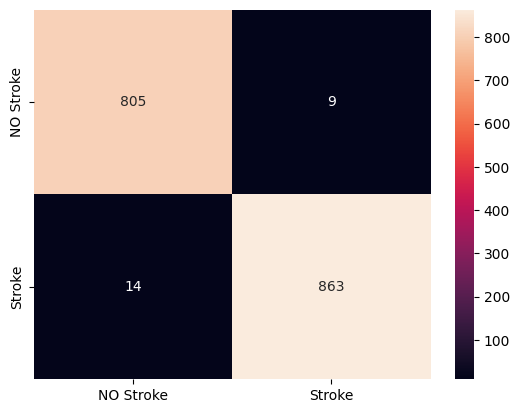

In [93]:
# Confussion matrix
baseline_cf = confusion_matrix(y_test, y_pred)
sns.heatmap(baseline_cf, annot=True, fmt="d", xticklabels=['NO Stroke', 'Stroke'], yticklabels=['NO Stroke', 'Stroke'])

## Hyperturning usando GridSearchCV

Realizamos de nuevo el proceso del modelo y compararemos resultados

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3}
Best score: 0.9856529649212578
              precision    recall  f1-score      support
No Stroke      0.982989  0.993857  0.988393   814.000000
Stroke         0.994240  0.984036  0.989112   877.000000
accuracy       0.988764  0.988764  0.988764     0.988764
macro avg      0.988614  0.988947  0.988753  1691.000000
weighted avg   0.988824  0.988764  0.988766  1691.000000


<AxesSubplot: >

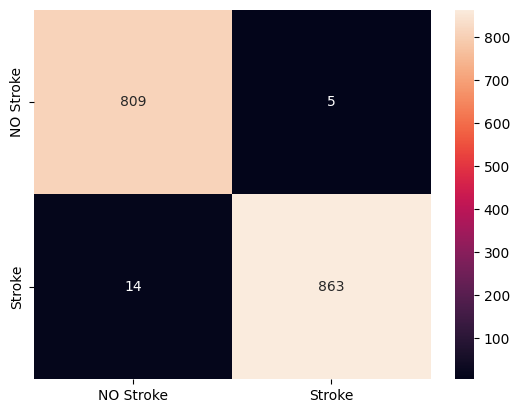

In [104]:
from sklearn.model_selection import GridSearchCV

# Define una grilla de valores para los hiperparámetros del modelo
param_grid = {'n_neighbors': [3, 5, 7],
              'metric': ['euclidean', 'manhattan']}

# Crea un modelo de KNN
knn = KNeighborsClassifier()

# Crea un objeto GridSearchCV con el modelo de KNN y la grilla de hiperparámetros
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Entrena el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train)

# Muestra la mejor combinación de hiperparámetros encontrada
print('Best parameters:', grid_search.best_params_)

# Muestra la mejor puntuación obtenida en validación cruzada
print('Best score:', grid_search.best_score_)

# Utiliza el modelo con los mejores hiperparámetros para hacer predicciones en el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Muestra las métricas de evaluación del modelo con los mejores hiperparámetros
report = classification_report(y_test, y_pred, output_dict=True, target_names=['No Stroke', 'Stroke'])
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Confussion matrix
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt="d", xticklabels=['NO Stroke', 'Stroke'], yticklabels=['NO Stroke', 'Stroke'])


## Conclusiones

Como conclusión, podemos observar que al utilizar hypertuning en el modelo KNN, se obtuvo un ligero aumento en el rendimiento del modelo en términos de precisión, recall y F1-score, así como un mejor score de validación cruzada.

Si bien estos cambios en el rendimiento son pequeños, podrían tener un impacto positivo en la aplicación práctica del modelo, ya que un modelo con mejor rendimiento puede ser más confiable y preciso en la clasificación de las muestras.